# Compare two datasets

Let's compare two pedestrian evaluations with different method: field count vs. cnn count. 

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

## Get NYC field count 

metadata - http://www.nyc.gov/html/dot/downloads/pdf/bi-annual-ped-count-readme.pdf

It has three different sorts of count
* \_am: weekday morning (7-9am)
* \_pm: weekday afternoon (4-7pm)
* \_md: weekend midday (12-2pm)

In [2]:
query = ("https://data.cityofnewyork.us/resource/cqsj-cfgu.json")
df_field = pd.read_json(query)
df_field.head()

,borough,the_geom,objectid,loc,street_nam,from_stree,to_street,index,may_07_am,may_07_pm,may_07_md,sept_07_am,sept_07_pm,sept_07_md,may_08_am,may_08_pm,may_08_md,sept_08_am,sept_08_pm,sept_08_md,may_09_am,may_09_pm,may_09_md,sept_09_am,sept_09_pm,sept_09_md,may_10_am,may_10_pm,may_10_md,sept_10_am,sept_10_pm,sept_10_md,may_11_am,may_11_pm,may_11_md,sept_11_am,sept_11_pm,sept_11_md,may_12_am,may_12_pm,may_12_md,sept_12_am,sept_12_pm,sept_12_md,may_13_am,may_13_pm,may_13_md,sept_13_am,sept_13_pm,sept_13_md,may_14_am,may_14_pm,may_14_md,sept_14_am,sept_14_pm,sept_14_md,may_15_am,may_15_pm,may_15_md,sept_15_am,sept_15_pm,sept_15_md,may_16_am,may_16_pm,may_16_md,sept_16_am,sept_16_pm,sept_16_md,may_17_am,may_17_pm,may_17_md,sept_17_am,sept_17_pm,sept_17_md,may_18_am,may_18_pm,may_18_md,sept_18_pm,sept_18_md,may_19_am,may_19_pm,may_19_md
0,Bronx,"{'type': 'Point', 'coordinates': [-73.90459140...",1,1,Broadway,West 231st Street,Naples Terrace,N,1189,4094,2508,734,2646,2939,802,4015,2631,1125,4310,3420,1001,3475,2832,991,4262,2469,1010,3609,3128,863,4119,2217,997,4440,2687,1328,3820,2428,1288,3328,3365,"1,268","4,315","2,276","1,210","4,710","3,825","1,206","4,590","3,008","1,220","4,384","2,641","1,450","4,646","2,996","1,788","4,980","3,033",1204,4520,2999,"1,246","4,531","2,686","1,309","3,642","2,830","1,916","5,893","2,776","1,111","4,044","2,731","1,271","4,502","2,899","4,464","2,967",-,-,-
1,Bronx,"{'type': 'Point', 'coordinates': [-73.92188432...",2,2,East 161st Street,Grand Concourse,Sheridan Avenue,Y,1511,3184,1971,1855,3754,1183,1136,2638,1522,1939,3283,1383,1351,3111,1304,1227,3137,2762,2077,3283,1409,1007,3069,1477,1734,3333,1772,2051,3525,1752,1233,1875,1912,"2,113","4,099","1,970","2,278","4,215","2,288","2,071","3,890","1,832","2,206","4,363","2,315","1,949","4,435","2,388","2,318","4,589","2,483",2005,4790,2512,"2,053","4,721","2,311","2,109","5,485","2,548","1,848","4,920","2,143","2,389","5,952","2,832","1,749","5,148","2,156","4,723","1,604","1,702","4,347","1,576"
2,Bronx,"{'type': 'Point', 'coordinates': [-73.89535781...",3,3,East Fordham Road,Valentine Avenue,Tiebout Avenue,Y,1832,12311,14391,1829,9215,15065,1061,8013,7927,2497,10010,8013,1689,8374,7472,2387,10655,6614,2285,10943,10424,2807,12658,7714,2289,15890,9167,2679,13548,8140,2125,7635,7022,"2,704","10,486","7,421","2,710","12,723","8,872","2,651","10,613","8,241","2,699","12,490","6,339","2,752","10,408","8,266","2,382","11,216","7,574",2733,10586,9072,"2,540","11,272","8,422","2,422","11,145","9,775","2,557","12,125","6,499","2,783","12,388","7,076","2,209","9,634","7,066","8,931","6,212","1,625","11,739","7,468"
3,Bronx,"{'type': 'Point', 'coordinates': [-73.87892467...",4,4,East Gun Hill Road,Bainbridge Avenue,Rochambeau Avenue,N,764,2673,1798,1360,1975,872,2102,3206,1989,3020,3915,1662,1536,2997,1672,2097,3135,1591,2954,3962,1717,1622,3006,1344,1661,2844,1510,1996,2836,1587,1906,2066,1261,"2,371","3,500","1,620","2,052","3,981","1,979","2,373","3,660","1,914","2,096","3,378","1,333","2,382","3,425","1,339","1,757","3,561","1,714",2256,2923,1574,"2,066","2,944","1,752","2,017","2,771","1,459","2,125","3,130","1,123","2,453","3,429","1,551","1,648","2,892","1,323","2,682","1,693",-,-,-
4,Bronx,"{'type': 'Point', 'coordinates': [-73.88956389...",5,5,East Tremont Avenue,Prospect Avenue,Clinton Avenue,N,650,2538,2334,1078,2739,2343,553,2438,1652,756,3095,1374,684,2660,2604,912,3637,2339,1075,5823,4085,1012,5785,3758,1093,6119,4274,1049,5859,3934,627,1503,2371,959,"3,140","2,273","1,007","4,175","2,854",760,"3,488","2,805",971,"3,586","2,460","1,019","3,184","2,366","1,055","3,710","2,554",1063,3296,2466,993,"3,625","2,492","1,101","3,336","2,501",980,"3,700","2,526","1,082","3,330","2,479","1,016","3,781","2,565","3,761","2,461",-,-,-


In [3]:
# missing value '-' to NaN marking
df_field = df_field.replace(to_replace = "-", value = np.nan)  

In [4]:
# change field count column data types to numeric
df_field[df_field.filter(regex='_am|_md|_pm').columns] = df_field.filter(regex='_am|_md|_pm')\
    .apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))

## Missing value check

### check row-wise

In [5]:
df_field.isnull().sum(axis=1)

0       3
1       0
2       0
3       3
4       3
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      3
13      0
14      0
15      0
16      3
17      0
18      0
19      3
20      0
21      3
22      0
23      0
24      3
25      0
26      3
27      0
28      9
29      3
30      0
31      0
32      3
33      3
34      0
35      0
36      0
37      0
38      3
39      0
40      0
41      0
42      3
43      3
44      0
45      3
46      0
47      3
48      0
49      3
50      0
51      3
52      0
53      0
54      0
55      0
56      0
57      0
58      3
59      0
60      3
61      3
62      0
63      3
64      3
65      3
66      3
67      0
68      3
69      3
70      3
71      0
72      0
73      0
74      3
75      3
76      0
77      3
78      3
79      0
80      3
81      0
82      3
83      3
84      0
85      3
86      4
87      3
88      4
89      3
90      3
91      3
92      3
93      3
94      3
95      3
96      3
97      1
98      4
99      0


In [6]:
# 101 has 19 missing values. what is it?
df_field.iloc[101]

borough                                      East River Bridges
the_geom      {'type': 'Point', 'coordinates': [-73.99094199...
objectid                                                    102
loc                                                         102
street_nam                        Manhattan Bridge - North Path
from_stree                                             midpoint
to_street                                                   NaN
index                                                         N
may_07_am                                                   NaN
may_07_pm                                                   NaN
may_07_md                                                   NaN
sept_07_am                                                  NaN
sept_07_pm                                                  NaN
sept_07_md                                                  NaN
may_08_am                                                   NaN
may_08_pm                               

In [7]:
# it is a bridge location. let's remove it.
df_field = df_field.drop(df_field.index[101])

### check column-wise

In [8]:
df_field.isnull().sum(axis=0)

borough        0
the_geom       0
objectid       0
loc            0
street_nam     0
from_stree     0
to_street     17
index          0
may_07_am      1
may_07_pm      1
may_07_md      1
sept_07_am     0
sept_07_pm     0
sept_07_md     0
may_08_am      0
may_08_pm      0
may_08_md      0
sept_08_am     1
sept_08_pm     1
sept_08_md     1
may_09_am      0
may_09_pm      0
may_09_md      0
sept_09_am     0
sept_09_pm     0
sept_09_md     0
may_10_am      0
may_10_pm      0
may_10_md      0
sept_10_am     0
sept_10_pm     0
sept_10_md     0
may_11_am      0
may_11_pm      0
may_11_md      0
sept_11_am     0
sept_11_pm     0
sept_11_md     0
may_12_am      0
may_12_pm      0
may_12_md      0
sept_12_am     0
sept_12_pm     0
sept_12_md     0
may_13_am      0
may_13_pm      0
may_13_md      0
sept_13_am     0
sept_13_pm     0
sept_13_md     0
may_14_am      0
may_14_pm      0
may_14_md      0
sept_14_am     0
sept_14_pm     0
sept_14_md     0
may_15_am      0
may_15_pm      0
may_15_md     

In [9]:
# may_19_* has many missing data. Let's remove them.
df_field = df_field.drop(columns=['may_19_am', 'may_19_pm', 'may_19_md'])

### Add aggregated columns

In [10]:
df_field['avg_field_all'] = df_field.filter(regex='_am|_md|_pm').mean(axis=1)
df_field['avg_field_md'] = df_field.filter(regex='_md').mean(axis=1)
df_field['avg_field_am'] = df_field.filter(regex='_am').mean(axis=1)
df_field['avg_field_pm'] = df_field.filter(regex='_pm').mean(axis=1)
df_field['avg_field_same_year'] = df_field.filter(regex='(_18_)').mean(axis=1)
df_field['avg_field_five_years'] = df_field.filter(regex='_18|_17|_16|_15|_14').mean(axis=1)

### relationship between all, md, am, pm
No big difference between md, am, and pm. 'all' seems to represent all other three well.

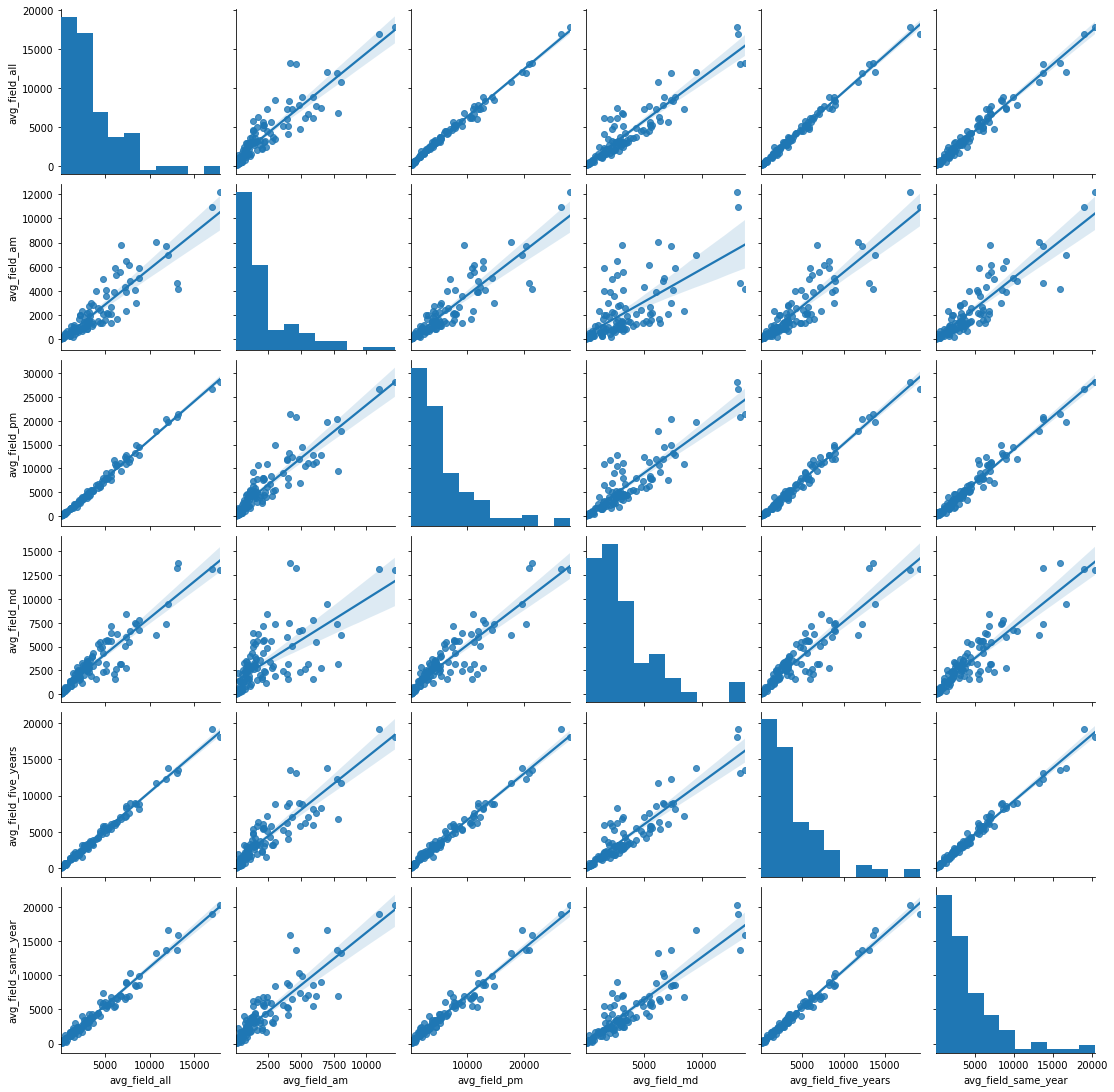

In [11]:
sns.pairplot(
    df_field[['avg_field_all', 'avg_field_am', 'avg_field_pm', 'avg_field_md', 'avg_field_five_years', 'avg_field_same_year']],
    kind='reg'
)

## Count from CNN

The result dataset includes the detection 'probability' of all identified person in the street view image of which score is higher than 0.05. From this dataset, we need to an aggregated estimation of a location's pedestrian volume.

We are going to test two different ways of aggregation.

1. Count the number of identified person 
  - count the number of people detected with a high probability (say, probability is greater than 0.7) to remove the effect of falsely detected person.

2. Sum of all 'person' scores at a location
  - sum all scores of identified person since 1) setting another threshold is arbitrary and 2) effect of detections with low score is low.

In [12]:
# read result dataset
df_cnn = pd.read_csv("../data/dataframe/nyc-cnn-exp.csv")
df_cnn

,image,score,lid
0,image_23_80.jpg,4.975166,23
1,image_25_40.jpg,1.099956,25
2,image_74_200.jpg,3.749829,74
3,image_25_100.jpg,1.780366,25
4,image_28_20.jpg,0.997827,28
...,...,...,...
2047,image_70_340.jpg,0.000000,70
2048,image_53_260.jpg,0.000000,53
2049,image_46_340.jpg,6.479526,46
2050,image_23_240.jpg,2.679454,23


In [13]:
df_cnn_agg = pd.DataFrame()
# sum all scores
df_cnn_agg['cnn_score_sum'] = df_cnn.groupby('lid')\
    .agg('sum')['score']
df_cnn_agg = df_cnn_agg.fillna(0)  # no count 
df_cnn_agg.head()

,cnn_score_sum
lid,
1,58.994938
2,11.921850
3,166.952693
4,17.379551
5,67.678092


In [14]:
df = df_field.merge(df_cnn_agg, left_on='loc', right_on='lid')\
    [['avg_field_all', 
      'avg_field_same_year', 
      'avg_field_five_years', 
      'cnn_score_sum', 'index']]

## Avg. Field Count Sept 2007- Sept 2018 vs. CNN Estimation

In [16]:
results = sm.OLS(df['avg_field_all'], df['cnn_score_sum']).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:          avg_field_all   R-squared (uncentered):                   0.849
Model:                            OLS   Adj. R-squared (uncentered):              0.848
Method:                 Least Squares   F-statistic:                              630.4
Date:                Fri, 20 Mar 2020   Prob (F-statistic):                    8.17e-48
Time:                        22:54:17   Log-Likelihood:                         -1018.0
No. Observations:                 113   AIC:                                      2038.
Df Residuals:                     112   BIC:                                      2041.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

## Avg. Field Count Recent 5 years vs. CNN Estimation

In [17]:
print(sm.OLS(df['avg_field_five_years'], df['cnn_score_sum']).fit().summary())

                                  OLS Regression Results                                 
Dep. Variable:     avg_field_five_years   R-squared (uncentered):                   0.849
Model:                              OLS   Adj. R-squared (uncentered):              0.847
Method:                   Least Squares   F-statistic:                              628.0
Date:                  Fri, 20 Mar 2020   Prob (F-statistic):                    9.79e-48
Time:                          22:54:42   Log-Likelihood:                         -1023.7
No. Observations:                   113   AIC:                                      2049.
Df Residuals:                       112   BIC:                                      2052.
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------

## ## Avg. Field Count 2018 vs. CNN Estimation

In [18]:
print(sm.OLS(df['avg_field_same_year'], df['cnn_score_sum']).fit().summary())

                                 OLS Regression Results                                 
Dep. Variable:     avg_field_same_year   R-squared (uncentered):                   0.841
Model:                             OLS   Adj. R-squared (uncentered):              0.839
Method:                  Least Squares   F-statistic:                              591.8
Date:                 Fri, 20 Mar 2020   Prob (F-statistic):                    1.64e-46
Time:                         22:55:08   Log-Likelihood:                         -1034.6
No. Observations:                  113   AIC:                                      2071.
Df Residuals:                      112   BIC:                                      2074.
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

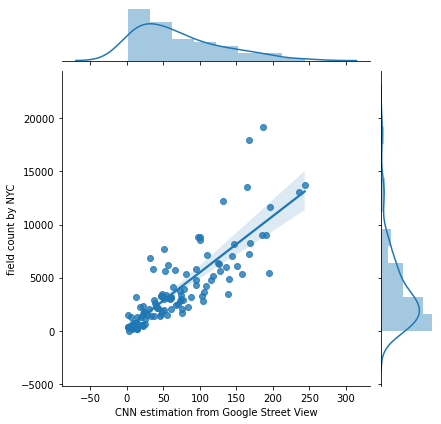

In [19]:
g= sns.jointplot(x="cnn_score_sum", 
              y="avg_field_five_years", 
              data=df, kind="reg")
plt.xlabel("CNN estimation from Google Street View")
plt.ylabel("field count by NYC")
plt.show()